# Data creation

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

data_folder = os.path.join(os.pardir, os.pardir, "data")
print(data_folder)

../../data


 ## Grouping simulation data

 Run until `Checks`, to create data file.

In [15]:
dict = pd.read_csv(os.path.join(data_folder, "RAW", "simulated", "README", "dictionary.csv"), names=["name", "class"], usecols=[0, 1], index_col=0)

dict

,class
name,
1-1.csv,Normal_75
1-2.csv,Normal_75
1-3.csv,Normal_75
1-4.csv,Normal_75
1-5.csv,Normal_75
...,...
61-96.csv,NoCompression_75_Cyl20
61-97.csv,NoCompression_75_Cyl20
61-98.csv,NoCompression_75_Cyl20


In [16]:
dict = pd.read_csv(os.path.join(data_folder, "RAW", "simulated", "README", "dictionary.csv"), names=["name", "class"], usecols=[0, 1], index_col=0)
simulated_data_folder = os.path.join(data_folder, "RAW", "simulated")

data = []

for filename in tqdm(os.listdir(simulated_data_folder)):
    if os.path.isfile(os.path.join(simulated_data_folder, filename)) and ".csv" in filename and not "dictionary" in filename:
        # Load simulated measurement
        df_temp = pd.read_csv(os.path.join(simulated_data_folder, filename), names=["angle", "speed"])

        # Add acceleration w.r. angle
        acc = np.diff(df_temp["speed"] / 60) / np.diff(df_temp["angle"]) # 1 / (s * rad)
        df_temp["acc"] = np.concatenate([acc, [acc[-1]]]) # * Copy last value to make up for shorter length

        # Add acceleration w.r. time
        sampling_rate = 1/10000
        acc_time = np.diff(df_temp["speed"] / 60) / sampling_rate # 1 / (s^2)
        df_temp["acc_time"] = np.concatenate([acc_time, [acc_time[-1]]]) # * Copy last value to make up for shorter length

        # Add distinguishin info
        data_class = dict.loc[filename]["class"].split("_")
        health_state = data_class[0]
        fault_cylinder = -1 if len(data_class) == 2 else int(data_class[2].replace("Cyl", ""))


        class_num, repetition = filename.replace(".csv", "").split("-")
        df_temp["class"] = int(class_num) - 1 # Simulated begins from 1 and measured from 0, thus - 1 here
        df_temp["repetition"] = int(repetition)
        df_temp["sample_point"] = np.arange(0, len(df_temp["angle"]))
        df_temp["health_state"] = health_state
        df_temp["fault_cylinder"] = fault_cylinder

        # Save
        data.append(df_temp.loc[:, ["class", "repetition", "health_state", "fault_cylinder", "sample_point", "angle", "speed", "acc", "acc_time"]])

data = pd.concat(data)
data = data.reset_index(drop=True)

data

100%|██████████| 6102/6102 [00:44<00:00, 137.37it/s]


,class,repetition,health_state,fault_cylinder,sample_point,angle,speed,acc,acc_time
0,8,64,Misfire,8,0,-0.004960,747.99996,-0.000430,-1.930000
1,8,64,Misfire,8,1,0.443836,747.98838,-0.000313,-1.405000
2,8,64,Misfire,8,2,0.892626,747.97995,-0.000286,-1.285000
3,8,64,Misfire,8,3,1.341412,747.97224,-0.000292,-1.310000
4,8,64,Misfire,8,4,1.790193,747.96438,-0.000267,-1.198333
...,...,...,...,...,...,...,...,...,...
9770149,6,50,Misfire,6,1596,717.548670,751.99161,-0.002323,-10.483333
9770150,6,50,Misfire,6,1597,718.000000,751.92871,-0.002406,-10.851667
9770151,6,50,Misfire,6,1598,718.450980,751.86360,-0.002379,-10.733333
9770152,6,50,Misfire,6,1599,718.902080,751.79920,-0.002261,-10.198333


In [17]:
# Save to disk
data.to_feather(os.path.join(data_folder, "processed", "simulated.feather"))

### Checks

In [18]:
data_simulated = pd.read_feather(os.path.join(data_folder, "processed", "simulated.feather"))
data_simulated["repetition"]

0          64
1          64
2          64
3          64
4          64
           ..
9770149    50
9770150    50
9770151    50
9770152    50
9770153    50
Name: repetition, Length: 9770154, dtype: int64

/var/folders/cx/1v2hhggj48s5vpt1wv2m167h0000gp/T/ipykernel_40413/3206539544.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


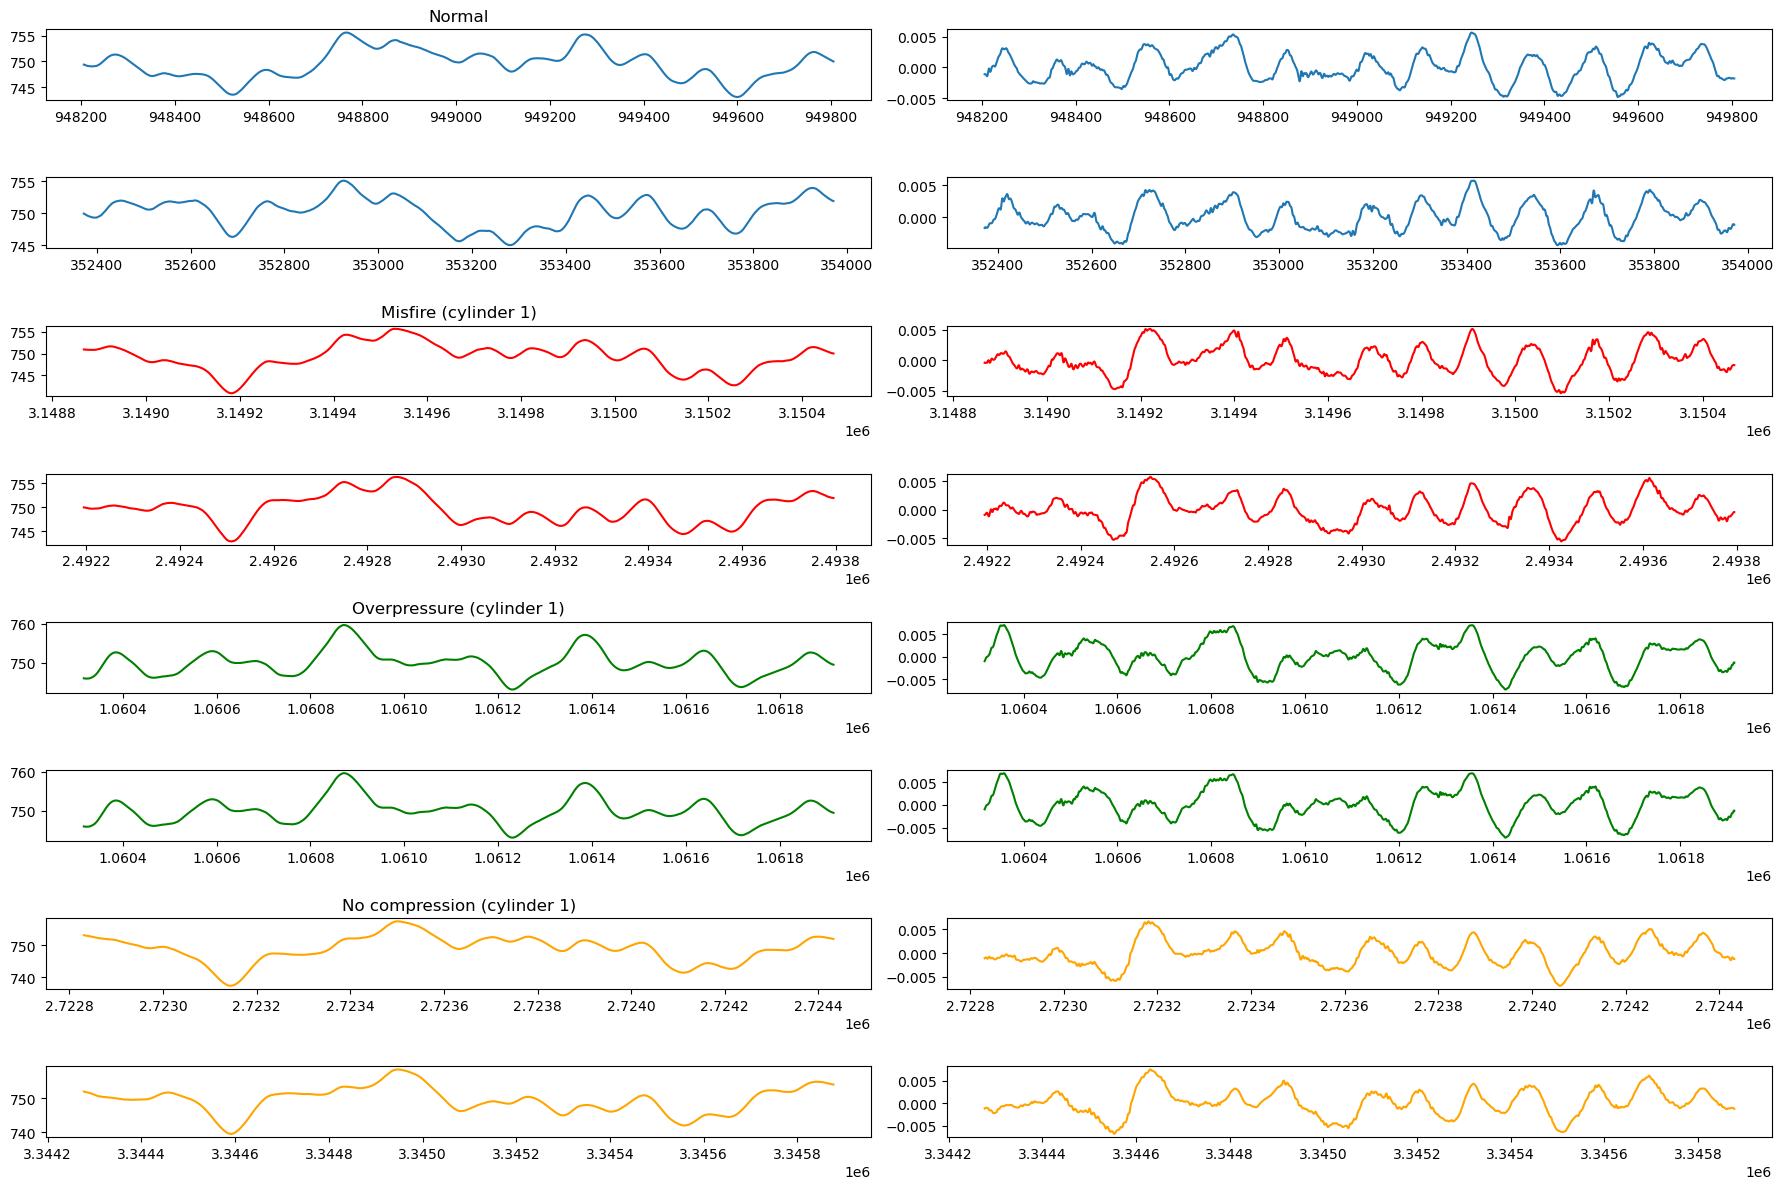

In [35]:
fig, axs = plt.subplots(8, 2, figsize=(18, 12))
axs = axs.flatten()
data_file_grouped = data_simulated.groupby(["class", "repetition"])

# Normal
axs[0].set_title("Normal")
axs[0].plot(data_file_grouped.get_group((0, 1))["speed"])
axs[1].plot(data_file_grouped.get_group((0, 1))["acc"])
axs[2].plot(data_file_grouped.get_group((0, 2))["speed"])
axs[3].plot(data_file_grouped.get_group((0, 2))["acc"])

# Misfire (cylinder 1)
axs[4].set_title("Misfire (cylinder 1)")
axs[4].plot(data_file_grouped.get_group((1, 1))["speed"], color="red")
axs[5].plot(data_file_grouped.get_group((1, 1))["acc"], color="red")
axs[6].plot(data_file_grouped.get_group((1, 2))["speed"], color="red")
axs[7].plot(data_file_grouped.get_group((1, 2))["acc"], color="red")

# Overpressure (cylinder 1)
axs[8].set_title("Overpressure (cylinder 1)")
axs[8].plot(data_file_grouped.get_group((21, 1))["speed"], color="green")
axs[9].plot(data_file_grouped.get_group((21, 1))["acc"], color="green")
axs[10].plot(data_file_grouped.get_group((21, 1))["speed"], color="green")
axs[11].plot(data_file_grouped.get_group((21, 1))["acc"], color="green")

# No compression
axs[12].set_title("No compression (cylinder 1)")
axs[12].plot(data_file_grouped.get_group((41, 1))["speed"], color="orange")
axs[13].plot(data_file_grouped.get_group((41, 1))["acc"], color="orange")
axs[14].plot(data_file_grouped.get_group((41, 2))["speed"], color="orange")
axs[15].plot(data_file_grouped.get_group((41, 2))["acc"], color="orange")

fig.tight_layout()
fig.show()

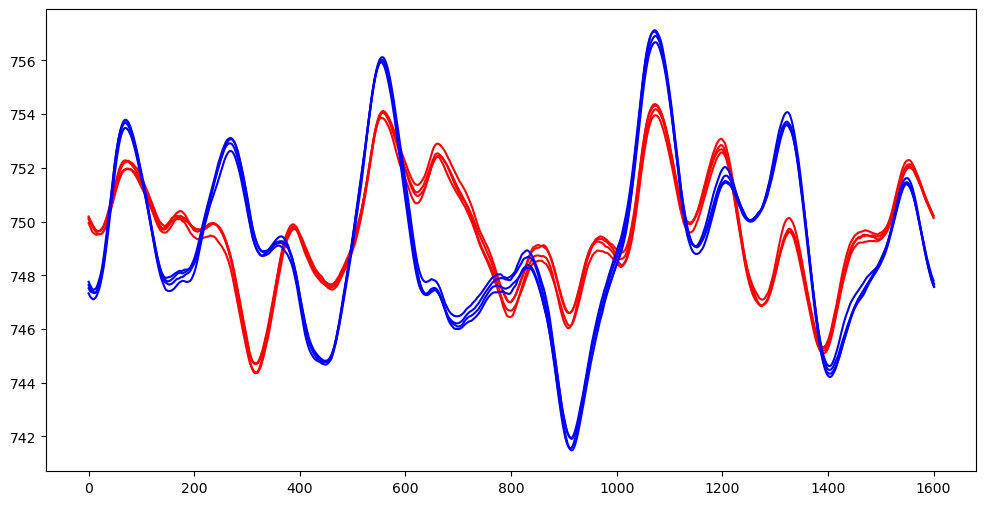

In [57]:
plt.figure(figsize=(12, 6))

sample = 55

for i in range(4):
    normal = data_file_grouped.get_group((0, sample + i))["speed"]
    plt.plot(np.arange(len(normal)), normal, c="red")

for i in range(4):
    normal = data_file_grouped.get_group((21, sample + i))["speed"]
    plt.plot(np.arange(len(normal)), normal, c="blue")
# faulty = data_file_grouped.get_group((2, sample))["speed"]

# plt.plot(np.arange(len(normal)), normal)
# plt.plot(np.arange(len(faulty)), faulty)

## Measured data

Run until `Checks`, to create data file.

In [20]:
dict = pd.read_csv(os.path.join(data_folder, "RAW", "measured", "README", "dictionary.csv"), names=["name", "class"], usecols=[0, 1], index_col=0)
measured_data_folder = os.path.join(data_folder, "RAW", "measured")

data = []

for filename in tqdm(os.listdir(measured_data_folder)):
    if os.path.isfile(os.path.join(measured_data_folder, filename)) and ".csv" in filename and not "dictionary" in filename:
        # Load simulated measurement
        df_temp = pd.read_csv(os.path.join(measured_data_folder, filename), names=["angle", "speed"])

        # Add acceleration w.r. angle
        acc = np.diff(df_temp["speed"] / 60) / np.diff(df_temp["angle"]) # 1 / (s * rad)
        df_temp["acc"] = np.concatenate([acc, [acc[-1]]]) # * Copy last value to make up for shorter length

        # Add acceleration w.r. time
        sampling_rate = 1/10000
        acc_time = np.diff(df_temp["speed"] / 60) / sampling_rate # 1 / (s^2)
        df_temp["acc_time"] = np.concatenate([acc_time, [acc_time[-1]]]) # * Copy last value to make up for shorter length

        # Add distinguishing info
        data_class = dict.loc[filename]["class"].split("_")
        health_state = data_class[0]
        fault_cylinder = -1 if len(data_class) == 2 else int(data_class[2].replace("Cyl", ""))

        class_num, repetition = filename.replace(".csv", "").split("-")
        df_temp["class"] = int(class_num)
        df_temp["repetition"] = int(repetition)
        df_temp["sample_point"] = np.arange(0, len(df_temp["angle"]))
        df_temp["health_state"] = health_state
        df_temp["fault_cylinder"] = fault_cylinder

        # Save
        data.append(df_temp.loc[:, ["class", "repetition", "health_state", "fault_cylinder", "sample_point", "angle", "speed", "acc", "acc_time"]])

data = pd.concat(data)
data = data.reset_index(drop=True)

data

100%|██████████| 212/212 [00:01<00:00, 127.63it/s]


,class,repetition,health_state,fault_cylinder,sample_point,angle,speed,acc,acc_time
0,0,40,Normal,-1,0,0.132250,754.332729,-0.002189,-9.963290
1,0,40,Normal,-1,1,0.587424,754.272950,-0.002189,-9.963290
2,0,40,Normal,-1,2,1.042599,754.213170,-0.002189,-9.963290
3,0,40,Normal,-1,3,1.497773,754.153390,-0.002189,-9.963290
4,0,40,Normal,-1,4,1.952947,754.093611,-0.002189,-9.963290
...,...,...,...,...,...,...,...,...,...
335899,0,59,Normal,-1,1594,717.761980,752.264357,0.000968,4.397529
335900,0,59,Normal,-1,1595,718.216198,752.290742,0.000968,4.397529
335901,0,59,Normal,-1,1596,718.670415,752.317127,0.000968,4.397529
335902,0,59,Normal,-1,1597,719.124633,752.343512,0.000968,4.397529


In [6]:
# Save to disk
data.to_feather(os.path.join(data_folder, "processed", "measured.feather"))

NameError: name 'data' is not defined

### Checks

In [ ]:
data_measured = pd.read_feather(os.path.join(data_folder, "processed", "measured.feather"))

NameError: name 'data' is not defined

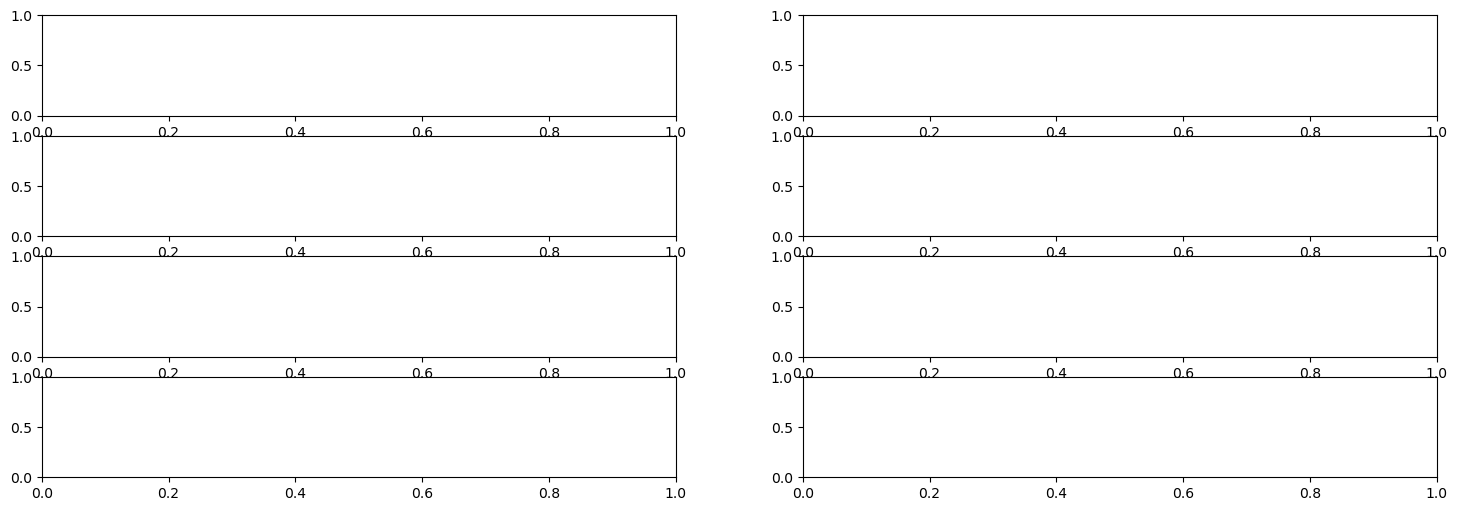

In [ ]:
fig, axs = plt.subplots(4, 2, figsize=(18, 6))
axs = axs.flatten()
data_file_grouped = data.groupby(["class", "repetition"])

# Normal
axs[0].set_title("Normal")
axs[0].plot(data_file_grouped.get_group((0, 1))["speed"])
axs[1].plot(data_file_grouped.get_group((0, 1))["acc"])
axs[2].plot(data_file_grouped.get_group((0, 2))["speed"])
axs[3].plot(data_file_grouped.get_group((0, 2))["acc"])

# Misfire (cylinder 1)
axs[4].set_title("Misfire (cylinder 1)")
axs[4].plot(data_file_grouped.get_group((1, 98))["speed"], color="red")
axs[5].plot(data_file_grouped.get_group((1, 98))["acc"], color="red")
axs[6].plot(data_file_grouped.get_group((1, 99))["speed"], color="red")
axs[7].plot(data_file_grouped.get_group((1, 99))["acc"], color="red")

fig.tight_layout()

In [ ]:
def ra(samples, pad_sizes, ra_window):
    # Through numpy
    samples = samples.numpy()
    # Pad
    samples = np.concatenate(
        [samples[:, :, : pad_sizes[0]], samples, samples[:, :, -pad_sizes[1] :]],
        axis=-1,
    )
    samples = np.apply_along_axis(lambda m: np.convolve(m, np.ones([ra_window]) / ra_window, mode="valid"), axis=-1, arr=samples)

    return torch.tensor(samples)

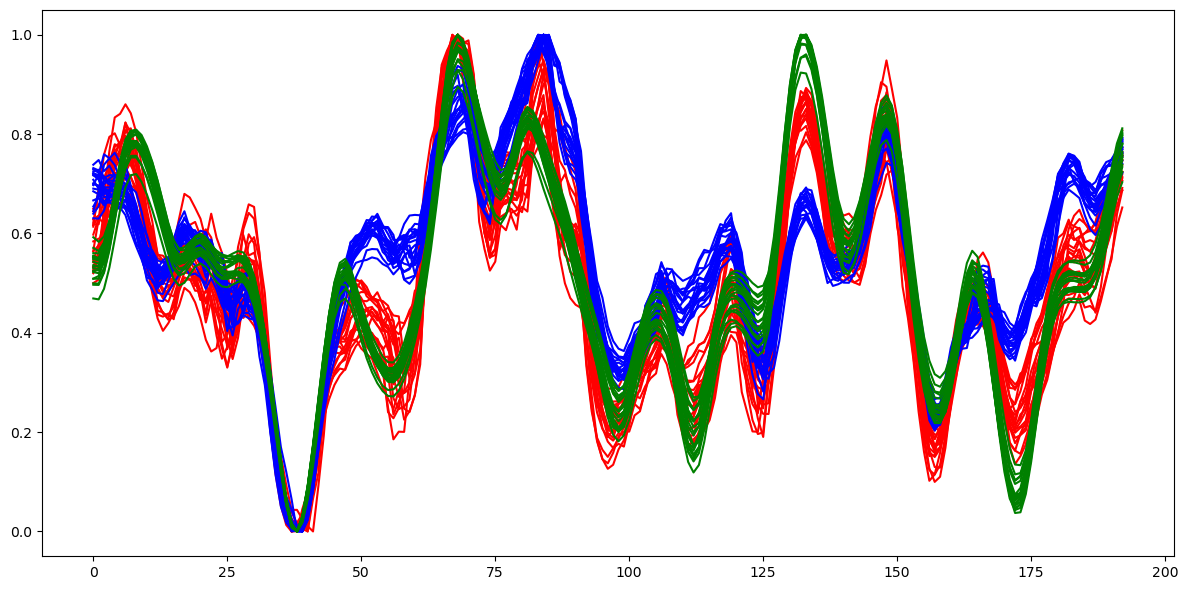

In [15]:


plt.figure(figsize=(12, 6))

def ra(sample, window_size):
    return np.convolve(sample, np.ones(window_size) / window_size, mode="valid")

def min_max(sample):
    return (sample - sample.min()) / (sample.max() - sample.min())

sample = 6
window_size = 30
subsample = 8
show = [True, True, True, False]
offset = 30

data_measured = pd.read_feather(os.path.join(data_folder, "processed", "measured.feather"))
data_file_grouped = data_measured.groupby(["class", "repetition"])

if show[0]:
    for i in range(20):
        normal = data_file_grouped.get_group((0, sample + i))["speed"]
        normal = ra(normal, window_size)
        normal = normal[offset:]
        normal = normal[::subsample]
        normal = min_max(normal)
        plt.plot(np.arange(len(normal)), normal, c="red")

if show[1]:
    for i in range(20):
        normal = data_file_grouped.get_group((1, sample + i))["speed"]
        normal = ra(normal, window_size)
        normal = normal[offset:]
        normal = normal[::subsample]
        normal = min_max(normal)
        plt.plot(np.arange(len(normal)), normal, c="blue")

data_simulated = pd.read_feather(os.path.join(data_folder, "processed", "simulated.feather"))
data_file_grouped = data_simulated.groupby(["class", "repetition"])

if show[2]:
    for i in range(20):
        normal = data_file_grouped.get_group((0, sample + i))["speed"]
        normal = ra(normal, window_size)
        normal = normal[:-offset]
        normal = normal[::subsample]
        normal = min_max(normal)
        plt.plot(np.arange(len(normal)), normal, c="green")

if show[3]:
    for i in range(20):
        normal = data_file_grouped.get_group((1, sample + i))["speed"]
        normal = ra(normal, window_size)
        normal = normal[:-offset]
        normal = normal[::subsample]
        normal = min_max(normal)
        plt.plot(np.arange(len(normal)), normal, c="yellow")

plt.tight_layout()

## Simulated VS Measured

In [ ]:
data_simulated = pd.read_feather(os.path.join(data_folder, "processed", "simulated.feather"))
data_measured = pd.read_feather(os.path.join(data_folder, "processed", "measured.feather"))

simulated_grouped = data_simulated.groupby(["class", "repetition"])
measured_grouped = data_measured.groupby(["class", "repetition"])

# rolling_average_window = 25
rolling_average_window = 50
subsampling_window = 10

def rolling_average(array, window_size):
    return np.convolve(array, np.ones(window_size) / window_size, mode="valid")

/var/folders/cx/1v2hhggj48s5vpt1wv2m167h0000gp/T/ipykernel_40413/1755458761.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


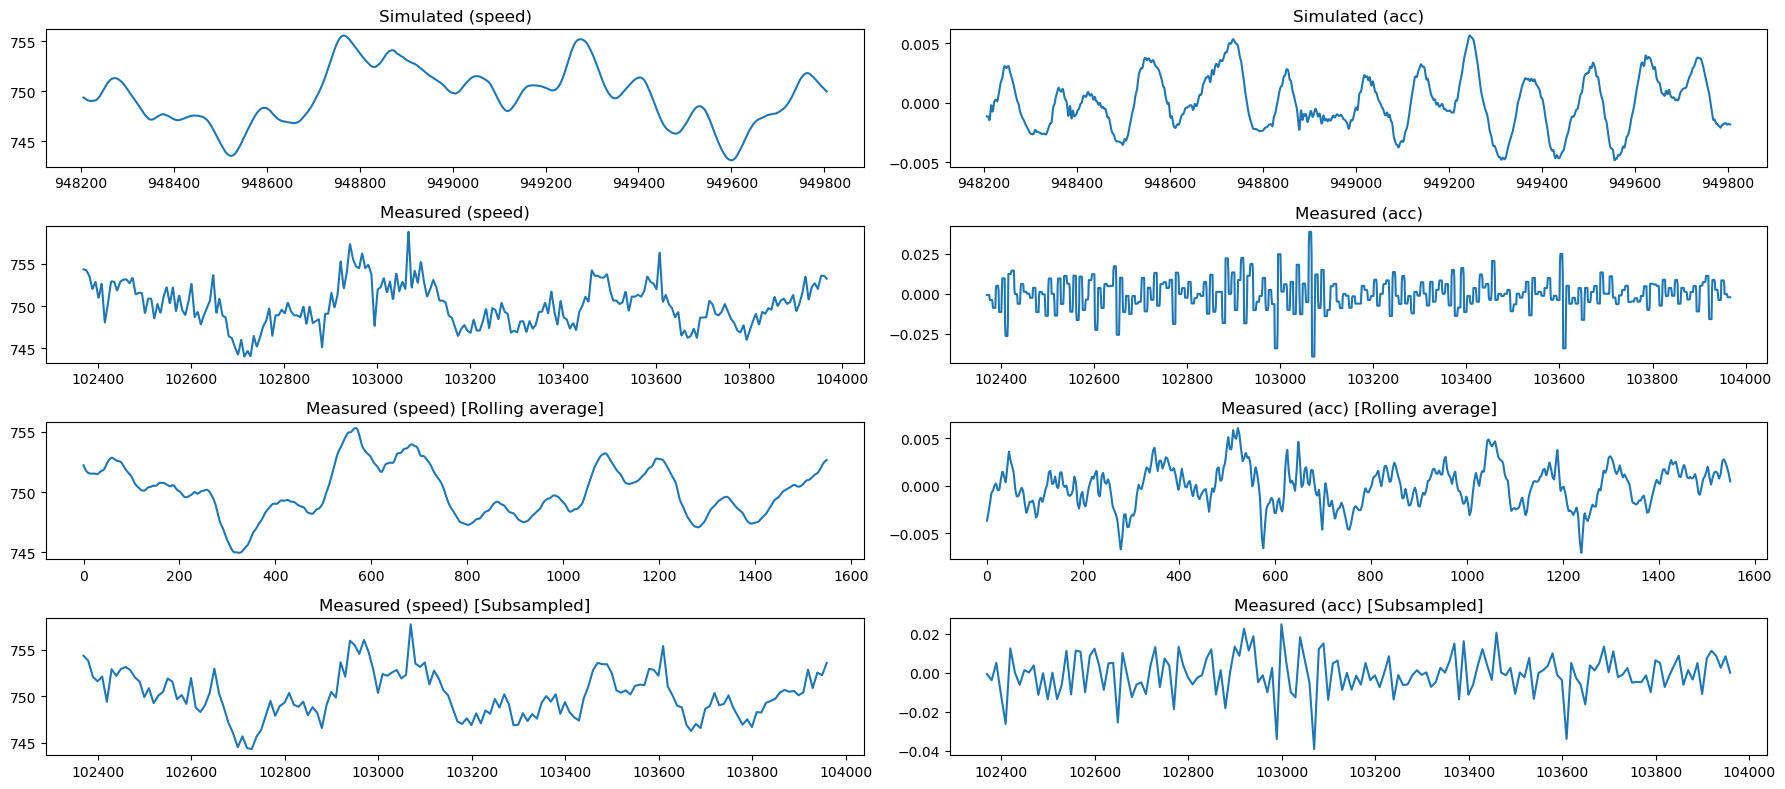

In [ ]:
# Normal

fig, axs = plt.subplots(4, 2, figsize=(18, 8))
axs = axs.flatten()

# Simulated
axs[0].set_title("Simulated (speed)")
axs[0].plot(simulated_grouped.get_group((0, 1))["speed"])
axs[1].set_title("Simulated (acc)")
axs[1].plot(simulated_grouped.get_group((0, 1))["acc"])

# Measured
axs[2].set_title("Measured (speed)")
axs[2].plot(measured_grouped.get_group((0, 1))["speed"])
axs[3].set_title("Measured (acc)")
axs[3].plot(measured_grouped.get_group((0, 1))["acc"])

# Measured rolling average
axs[4].set_title("Measured (speed) [Rolling average]")
axs[4].plot(rolling_average(measured_grouped.get_group((0, 1))["speed"], rolling_average_window))
axs[5].set_title("Measured (acc) [Rolling average]")
axs[5].plot(rolling_average(measured_grouped.get_group((0, 1))["acc"], rolling_average_window))

# Measured subsampled
axs[6].set_title("Measured (speed) [Subsampled]")
axs[6].plot(measured_grouped.get_group((0, 1))["speed"][::subsampling_window])
axs[7].set_title("Measured (acc) [Subsampled]")
axs[7].plot(measured_grouped.get_group((0, 1))["acc"][::subsampling_window])

fig.tight_layout()
fig.show()


/var/folders/cx/1v2hhggj48s5vpt1wv2m167h0000gp/T/ipykernel_40413/3233591103.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


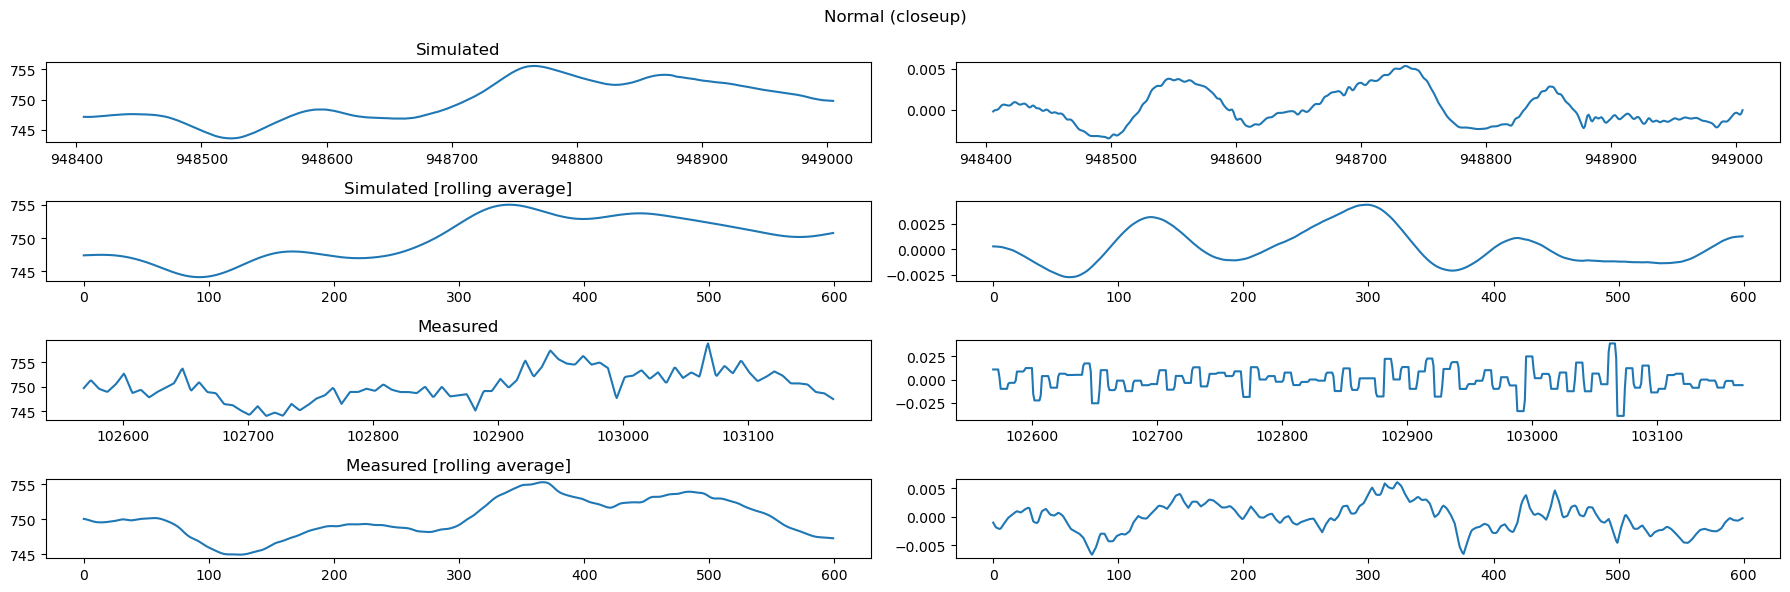

In [ ]:
# Normal (closeup)

closeup_start = 200
closeup_size = 600

fig, axs = plt.subplots(4, 2, figsize=(18, 6))
axs = axs.flatten()

fig.suptitle("Normal (closeup)")

axs[0].set_title("Simulated")
axs[0].plot(simulated_grouped.get_group((0, 1))["speed"][closeup_start:closeup_start + closeup_size])
axs[1].plot(simulated_grouped.get_group((0, 1))["acc"][closeup_start:closeup_start + closeup_size])

fig.suptitle("Normal (closeup)")

axs[2].set_title("Simulated [rolling average]")
axs[2].plot(rolling_average(simulated_grouped.get_group((0, 1))["speed"], rolling_average_window)[closeup_start:closeup_start + closeup_size])
axs[3].plot(rolling_average(simulated_grouped.get_group((0, 1))["acc"], rolling_average_window)[closeup_start:closeup_start + closeup_size])

axs[4].set_title("Measured")
axs[4].plot(measured_grouped.get_group((0, 1))["speed"][closeup_start:closeup_start + closeup_size])
axs[5].plot(measured_grouped.get_group((0, 1))["acc"][closeup_start:closeup_start + closeup_size])

axs[6].set_title("Measured [rolling average]")
axs[6].plot(rolling_average(measured_grouped.get_group((0, 1))["speed"], rolling_average_window)[closeup_start:closeup_start + closeup_size])
axs[7].plot(rolling_average(measured_grouped.get_group((0, 1))["acc"], rolling_average_window)[closeup_start:closeup_start + closeup_size])

fig.tight_layout()
fig.show()

/var/folders/cx/1v2hhggj48s5vpt1wv2m167h0000gp/T/ipykernel_40413/1272237928.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


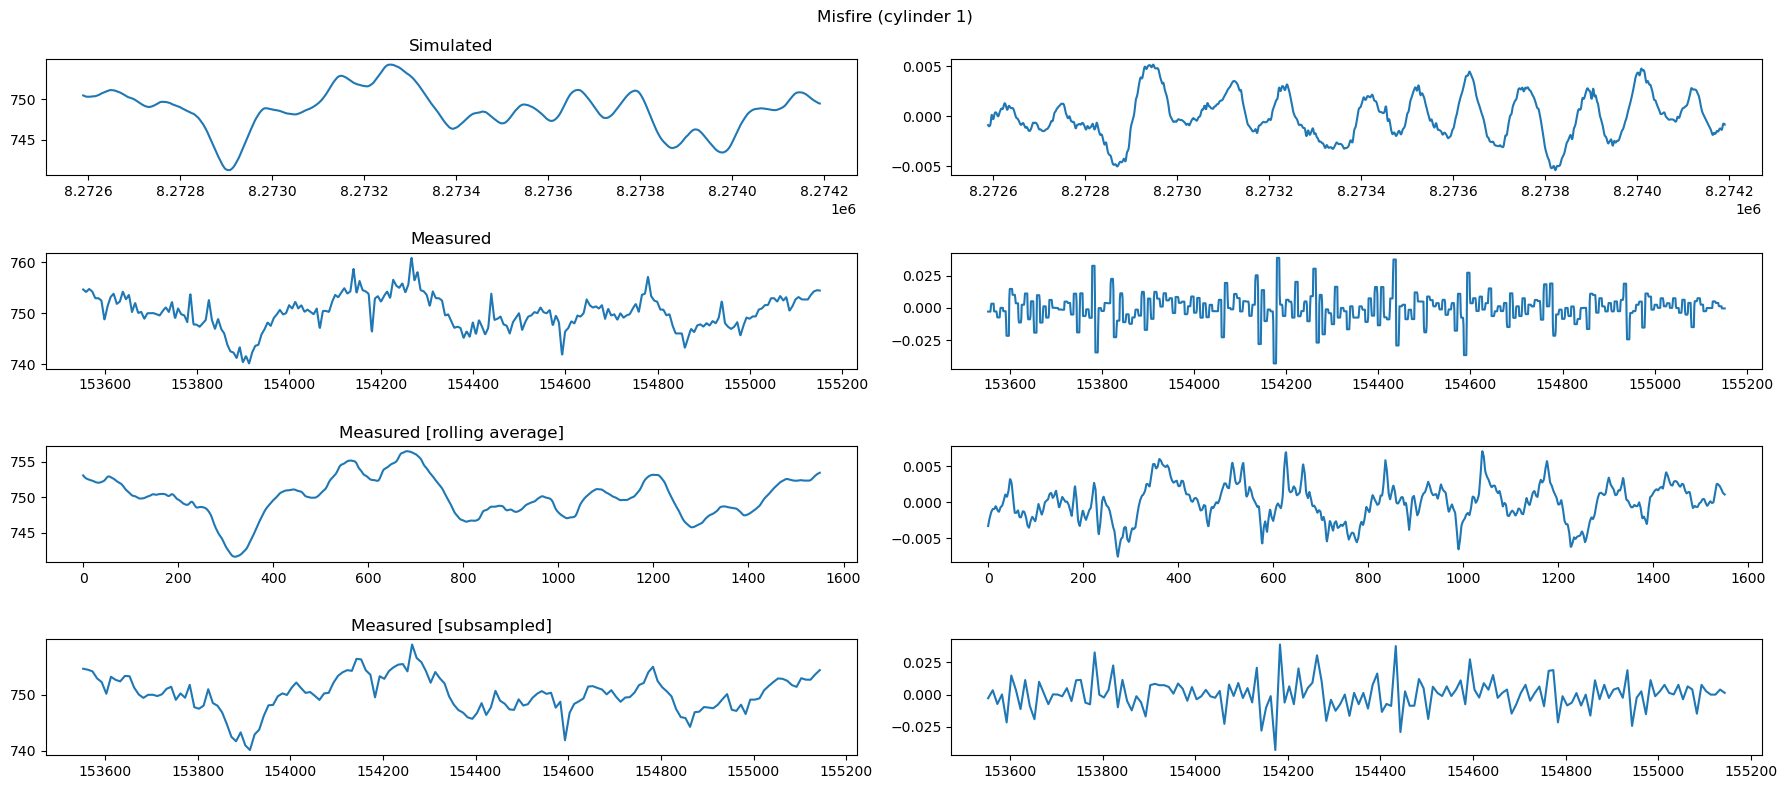

In [ ]:
# Misfire (cylinder 1)

fig, axs = plt.subplots(4, 2, figsize=(18, 8))
axs = axs.flatten()

fig.suptitle("Misfire (cylinder 1)")

# Simulated
axs[0].set_title("Simulated")
axs[0].plot(simulated_grouped.get_group((1, 66))["speed"])
axs[1].plot(simulated_grouped.get_group((1, 66))["acc"])

# Measured
axs[2].set_title("Measured")
axs[2].plot(measured_grouped.get_group((1, 66))["speed"])
axs[3].plot(measured_grouped.get_group((1, 66))["acc"])

# Measured rolling average
axs[4].set_title("Measured [rolling average]")
axs[4].plot(rolling_average(measured_grouped.get_group((1, 66))["speed"], rolling_average_window))
axs[5].plot(rolling_average(measured_grouped.get_group((1, 66))["acc"], rolling_average_window))

# Measured subsampled
axs[6].set_title("Measured [subsampled]")
axs[6].plot(measured_grouped.get_group((1, 66))["speed"][::subsampling_window])
axs[7].plot(measured_grouped.get_group((1, 66))["acc"][::subsampling_window])

fig.tight_layout()
fig.show()